<a href="https://colab.research.google.com/github/benjuarez8/CS81C-Research-Bolivia/blob/main/cs81c_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [1]:
pip install Unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import itertools
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from xgboost.sklearn import XGBClassifier
from unidecode import unidecode
from itertools import cycle

#Load Data

Using same training and testing datasets from 2020 SURF project

In [3]:
training_data = pd.read_csv("https://raw.githubusercontent.com/benjuarez8/Bolivia-SURF-2020/master/CS81C/training_data.csv")
training_data.rename( columns={"Unnamed: 0":"ID"}, inplace=True )
testing_data = pd.read_csv("https://raw.githubusercontent.com/benjuarez8/Bolivia-SURF-2020/master/CS81C/testing_data.csv")
testing_data.rename( columns={"Unnamed: 0":"ID"}, inplace=True )

#Data Processing

Encoding fraud labels as -1 (vote stealing), 1 (ballot box stuffing), 0 (clean).

In [4]:
training_data["Fraud_num"] = [ -1 if type == "VS" else 1 if type == "BBS" else 
                              0 for type in training_data["Fraud.type"] ]

One-hot encoding for departments with other data processing.

In [5]:
training_departments = training_data["Department"].str.get_dummies()
training_data = pd.concat([training_data, training_departments], axis=1)
testing_departments = testing_data["Department"].str.get_dummies()
testing_data = pd.concat([testing_data, testing_departments], axis=1)
testing_data.rename( columns={"Potosí":unidecode("Potosí")}, inplace=True)

Separating data properly for training/testing.

In [6]:
train_labels = training_data["Fraud_num"]
# train_labels = training_data["Fraud.type"]
train = training_data[["Beni", "Chuquisaca", "Cochabamba", "La Paz", "Oruro", 
                       "Pando", "Potosi", "Santa Cruz", "Tarija", "Turnout", 
                       "MAS.vote"]]
test = testing_data[["Beni", "Chuquisaca", "Cochabamba", "La Paz", "Oruro", 
                     "Pando", "Potosi", "Santa Cruz", "Tarija", "Turnout", 
                     "MAS.vote"]]
print('Number of training locations (mesas) from synthetic data: %d' % (len(train)))
print('Number of testing locations (mesas) from actual data: %d' % (len(test)))

Number of training locations (mesas) from synthetic data: 32888
Number of testing locations (mesas) from actual data: 28883


Transforming into numpy arrays.

In [7]:
X_train = np.array(train)
y_train = np.array(train_labels)
X_test = np.array(test)

#Classification Models

In [8]:
rf_model = RandomForestClassifier(n_estimators=400, random_state=1)
gb_model = GradientBoostingClassifier()
knn_model = KNeighborsClassifier()
logr_model = LogisticRegression(max_iter = 1000)
xgb_model = XGBClassifier()

# Ensemble (averaging approach)

VotingClassifier with soft voting and equal weights is equivalent to an equally weighted averaging ensemble approach. This approach returns the predicted fraud label (VS, BBS, or Clean) as the argmax of the sum of the predicted probabilities.  With the weights parameter, specific weight values are designated to each of the 5 classifiers such that the predicted label probabilities for each classifier are multiplied by its respective weight before being averaged.  The following sources further detail this process:


*   https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
*   https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier

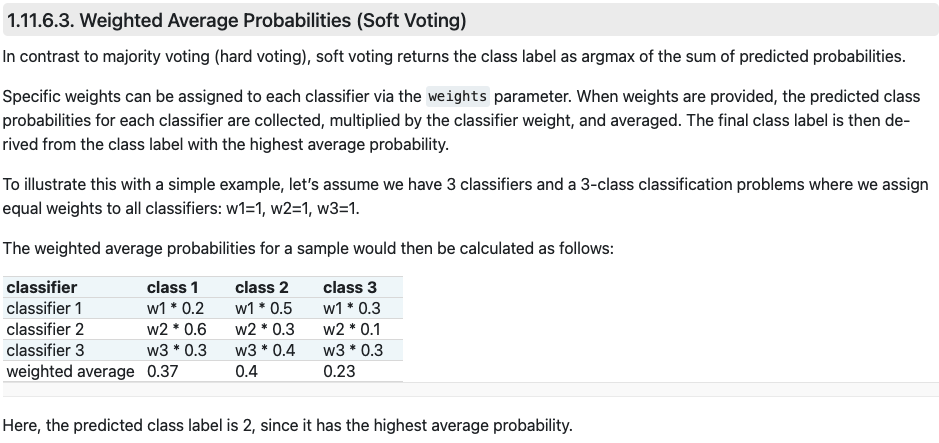

In [9]:
avg_model = VotingClassifier(estimators = [("RF", rf_model), 
                                              ("XGB", xgb_model), 
                                              ("KNN", knn_model), 
                                              ("LogR", logr_model), 
                                              ("GB", gb_model)], 
                                voting="soft", weights = [1,1,1,1,1])

In [10]:
seed = 8
np.random.seed(seed)
avg_model.fit(X_train, y_train)

VotingClassifier(estimators=[('RF',
                              RandomForestClassifier(n_estimators=400,
                                                     random_state=1)),
                             ('XGB', XGBClassifier()),
                             ('KNN', KNeighborsClassifier()),
                             ('LogR', LogisticRegression(max_iter=1000)),
                             ('GB', GradientBoostingClassifier())],
                 voting='soft', weights=[1, 1, 1, 1, 1])

In [11]:
avg_pred = avg_model.predict(X_test)

Combines predictions with election data for each location.

In [12]:
avg_ensemble_test = test.copy()
pd.options.mode.chained_assignment = None
# avg_ensemble_test["Pred_Fraud_type"] = avg_pred.tolist()
avg_ensemble_test["Pred_Fraud_num"] = avg_pred.tolist()
avg_ensemble_test["Pred_Fraud_type"] = [ "VS" if type == -1 else "BBS" if 
                                        type == 1 else "Clean" for type in 
                                        avg_ensemble_test["Pred_Fraud_num"] ]
avg_ensemble_test["Department"] = testing_data["Department"]
avg_ensemble_test["Precinct"] = testing_data["Precinct"]
avg_ensemble_test["Municipality"] = testing_data["Municipality"]

In [13]:
avg_ensemble_test.to_csv("ensemble_avg_results.csv", index=False)

In [14]:
col_names = ["Clean", "At_Risk", "BBS_Risk", "VS_Risk", "Avg_Turnout", 
             "Avg_MAS_vote"]
avg_ensemble_results = pd.DataFrame(columns = col_names)
counts = avg_ensemble_test.Pred_Fraud_type.value_counts()
clean = counts[0] / (counts[0] + counts[1] + counts[2])
tot_risk = (counts[1] + counts[2]) / (counts[0] + counts[1] + counts[2])
bbs = counts[1] / (counts[0] + counts[1] + counts[2])
vs = counts[2] / (counts[0] + counts[1] + counts[2])
avg_turnout = avg_ensemble_test["Turnout"].mean()
avg_vote = avg_ensemble_test["MAS.vote"].mean()
avg_ensemble_results.loc[len(avg_ensemble_results)] = [round(100*clean,2), 
                                                       round(100*tot_risk,2), 
                                                       round(100*bbs,2), 
                                                       round(100*vs,2), 
                                                       round(100*avg_turnout,2), 
                                                       round(avg_vote,2)]

Turnout and MAS vote share are the two main predictors.  Higher turnout is related to ballot box stuffing while higher MAS vote share is related to vote stealing.

In [15]:
avg_ensemble_results.to_csv("ensemble_avg_tot_results.csv", index=False)
avg_ensemble_results

,Clean,At_Risk,BBS_Risk,VS_Risk,Avg_Turnout,Avg_MAS_vote
0,86.16,13.84,9.19,4.66,89.8,0.46


In [16]:
col_names = ["Department", "Clean", "At_Risk", "BBS_Risk", "VS_Risk", 
             "Avg_Turnout", "Avg_MAS_vote"]
avg_ensemble_dep_results = pd.DataFrame(columns = col_names)
for dep in avg_ensemble_test["Department"].unique():
    counts = avg_ensemble_test[avg_ensemble_test["Department"] == 
                               dep].Pred_Fraud_type.value_counts()
    clean = counts[0] / (counts[0] + counts[1] + counts[2])
    tot_risk = (counts[1] + counts[2]) / (counts[0] + counts[1] + counts[2])
    bbs = counts[1] / (counts[0] + counts[1] + counts[2])
    vs = counts[2] / (counts[0] + counts[1] + counts[2])
    avg_turnout = avg_ensemble_test[avg_ensemble_test["Department"] == 
                                    dep]["Turnout"].mean()
    avg_vote = avg_ensemble_test[avg_ensemble_test["Department"] == 
                                 dep]["MAS.vote"].mean()
    avg_ensemble_dep_results.loc[len(avg_ensemble_dep_results)] = [dep, 
                                                      round(100*clean,2), 
                                                      round(100*tot_risk,2), 
                                                      round(100*bbs,2), 
                                                      round(100*vs,2), 
                                                      round(100*avg_turnout,2), 
                                                      round(avg_vote,2)]
avg_ensemble_dep_results = avg_ensemble_dep_results.sort_values(by = "Clean")
avg_ensemble_dep_results.reset_index(drop=True, inplace=True)

Results for each of the 9 departments across Bolivia.

In [17]:
avg_ensemble_dep_results.to_csv("ensemble_avg_dep_results.csv", index=False)
avg_ensemble_dep_results

,Department,Clean,At_Risk,BBS_Risk,VS_Risk,Avg_Turnout,Avg_MAS_vote
0,Cochabamba,77.37,22.63,11.39,11.24,90.28,0.57
1,La Paz,83.84,16.16,12.88,3.28,91.75,0.53
2,Potosí,86.74,13.26,6.72,6.54,88.87,0.46
3,Oruro,86.75,13.25,11.11,2.13,91.09,0.47
4,Santa Cruz,90.52,9.48,7.56,1.92,88.83,0.34
5,Chuquisaca,91.43,8.57,5.69,2.88,88.41,0.40
6,Tarija,94.36,5.64,2.85,2.79,87.26,0.39
7,Beni,95.06,4.94,2.70,2.24,86.17,0.34
8,Pando,95.42,4.58,3.05,1.53,84.31,0.43


In [18]:
avg_ensemble_test[avg_ensemble_test["Municipality"] == "Yocalla"].Pred_Fraud_type.value_counts()

Clean    15
BBS       1
Name: Pred_Fraud_type, dtype: int64

In [19]:
avg_ensemble_test.loc[avg_ensemble_test.Municipality == "Yocalla", 'Pred_Fraud_type'].value_counts().reindex(avg_ensemble_test.Pred_Fraud_type.unique(), fill_value=0)

Clean    15
BBS       1
VS        0
Name: Pred_Fraud_type, dtype: int64

In [65]:
avg_ensemble_test.Municipality.value_counts()['Yocalla']

16

In [69]:
col_names = ["Municipality", "Department", "Clean", "At_Risk", "BBS_Risk", 
             "VS_Risk", "Avg_Turnout", "Avg_MAS_vote", "Num_Mesas"]
avg_ensemble_mun_results = pd.DataFrame(columns = col_names)
for municip in avg_ensemble_test["Municipality"].unique():
  dep = avg_ensemble_test.loc[avg_ensemble_test["Municipality"] == 
                              municip]["Department"].iloc[0]
  # counts = avg_ensemble_test[avg_ensemble_test["Municipality"] == 
  #                            municip].Pred_Fraud_type.value_counts()
  counts = avg_ensemble_test.loc[avg_ensemble_test.Municipality == municip, 
                                 'Pred_Fraud_type'].value_counts().reindex(avg_ensemble_test.Pred_Fraud_type.unique(), 
                                 fill_value=0)
  # if (len(counts) > 2):
  clean = counts[0] / (counts[0] + counts[1] + counts[2])
  tot_risk = (counts[1] + counts[2]) / (counts[0] + counts[1] + counts[2])
  bbs = counts[1] / (counts[0] + counts[1] + counts[2])
  vs = counts[2] / (counts[0] + counts[1] + counts[2])
  avg_turnout = avg_ensemble_test[avg_ensemble_test["Municipality"] == 
                                  municip]["Turnout"].mean()
  avg_vote = avg_ensemble_test[avg_ensemble_test["Municipality"] == 
                                municip]["MAS.vote"].mean()
  num_mesas = avg_ensemble_test.Municipality.value_counts()[municip]
  avg_ensemble_mun_results.loc[len(avg_ensemble_mun_results)] = [municip, dep, 
                                                  round(100*clean,2), 
                                                  round(100*tot_risk,2), 
                                                  round(100*bbs,2), 
                                                  round(100*vs,2), 
                                                  round(100*avg_turnout,2), 
                                                  round(avg_vote,2), num_mesas]
avg_ensemble_mun_results = avg_ensemble_mun_results.sort_values(by = 
                                                                    "Clean")
avg_ensemble_mun_results.reset_index(drop=True, inplace=True)

Results further broken down to the municipality level.

In [70]:
avg_ensemble_mun_results.to_csv("ensemble_avg_mun_results.csv", index=False)
avg_ensemble_mun_results

,Municipality,Department,Clean,At_Risk,BBS_Risk,VS_Risk,Avg_Turnout,Avg_MAS_vote,Num_Mesas
0,Malla,La Paz,0.0,100.0,66.67,33.33,96.27,0.83,3
1,San Pablo,Potosí,0.0,100.0,100.00,0.00,94.30,0.40,1
2,Vila Vila,Cochabamba,0.0,100.0,50.00,50.00,93.65,0.95,6
3,Raqaypampa,Cochabamba,0.0,100.0,0.00,100.00,89.97,0.96,13
4,Catacora,La Paz,0.0,100.0,0.00,100.00,93.50,0.79,1
...,...,...,...,...,...,...,...,...,...
321,El Choro,Oruro,100.0,0.0,0.00,0.00,88.57,0.76,7
322,Choquecota,Oruro,100.0,0.0,0.00,0.00,86.50,0.84,3
323,Roboré,Santa Cruz,100.0,0.0,0.00,0.00,84.79,0.26,46
324,San Juan,Santa Cruz,100.0,0.0,0.00,0.00,87.98,0.47,20


In [72]:
avg_ensemble_mun_results[avg_ensemble_mun_results.Num_Mesas > 20].sort_values(by=['Clean'])

,Municipality,Department,Clean,At_Risk,BBS_Risk,VS_Risk,Avg_Turnout,Avg_MAS_vote,Num_Mesas
8,Vacas,Cochabamba,4.55,95.45,27.27,68.18,92.70,0.91,22
9,Villa Tunari,Cochabamba,7.11,92.89,38.58,54.31,93.87,0.94,197
11,Puerto Villarroel,Cochabamba,8.61,91.39,33.11,58.28,93.40,0.91,151
12,Tapacarí,Cochabamba,11.90,88.10,19.05,69.05,91.40,0.93,42
14,Pocona,Cochabamba,16.67,83.33,20.83,62.50,92.48,0.91,24
...,...,...,...,...,...,...,...,...,...
264,San Matías,Santa Cruz,100.00,0.00,0.00,0.00,82.50,0.46,34
261,San Ramón,Santa Cruz,100.00,0.00,0.00,0.00,85.52,0.37,32
256,Monteagudo,Chuquisaca,100.00,0.00,0.00,0.00,86.87,0.44,59
268,Magdalena,Beni,100.00,0.00,0.00,0.00,86.56,0.34,24


In [74]:
# mun_results_to_latex = avg_ensemble_mun_results[avg_ensemble_mun_results.Num_Mesas > 20].sort_values(by=['Clean'])
avg_ensemble_mun_results[avg_ensemble_mun_results.Num_Mesas > 20].sort_values(by=['Clean']).head(20).to_latex()

'\\begin{tabular}{lllrrrrrrl}\n\\toprule\n{} &       Municipality &  Department &  Clean &  At\\_Risk &  BBS\\_Risk &  VS\\_Risk &  Avg\\_Turnout &  Avg\\_MAS\\_vote & Num\\_Mesas \\\\\n\\midrule\n8  &              Vacas &  Cochabamba &   4.55 &    95.45 &     27.27 &    68.18 &        92.70 &          0.91 &        22 \\\\\n9  &       Villa Tunari &  Cochabamba &   7.11 &    92.89 &     38.58 &    54.31 &        93.87 &          0.94 &       197 \\\\\n11 &  Puerto Villarroel &  Cochabamba &   8.61 &    91.39 &     33.11 &    58.28 &        93.40 &          0.91 &       151 \\\\\n12 &           Tapacarí &  Cochabamba &  11.90 &    88.10 &     19.05 &    69.05 &        91.40 &          0.93 &        42 \\\\\n14 &             Pocona &  Cochabamba &  16.67 &    83.33 &     20.83 &    62.50 &        92.48 &          0.91 &        24 \\\\\n15 &              Palca &      La Paz &  17.65 &    82.35 &      8.82 &    73.53 &        92.42 &          0.87 &        34 \\\\\n16 &             Totora

#Ensemble (weighted average approach)

VotingClassifier with soft voting and varying weights is equivalent to an weighted averaging ensemble approach. A higher weight value would imply that the corresponding classifier has more influence on the predicted label.  This approach returns the predicted fraud label (VS, BBS, or Clean) as the argmax of the sum of the predicted probabilities.  With the weights parameter, specific weight values are designated to each of the 5 classifiers such that the predicted label probabilities for each classifier are multiplied by its respective weight before being averaged.  The following sources further detail this process:


*   https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
*   https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier

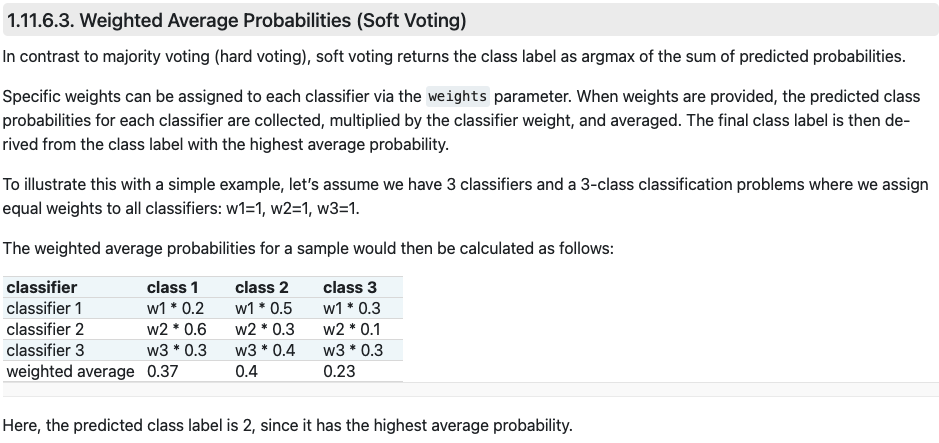

In [22]:
weighted_avg_model = VotingClassifier(estimators = [("RF", rf_model), 
                                              ("XGB", xgb_model), 
                                              ("KNN", knn_model), 
                                              ("LogR", logr_model), 
                                              ("GB", gb_model)], 
                                voting="soft", weights = [2,3,1,4,5])

In [23]:
seed = 8
np.random.seed(seed)
weighted_avg_model.fit(X_train, y_train)

VotingClassifier(estimators=[('RF',
                              RandomForestClassifier(n_estimators=400,
                                                     random_state=1)),
                             ('XGB', XGBClassifier()),
                             ('KNN', KNeighborsClassifier()),
                             ('LogR', LogisticRegression(max_iter=1000)),
                             ('GB', GradientBoostingClassifier())],
                 voting='soft', weights=[2, 3, 1, 4, 5])

In [24]:
weighted_pred = weighted_avg_model.predict(X_test)

In [25]:
weighted_ensemble_test = test.copy()
pd.options.mode.chained_assignment = None
weighted_ensemble_test["Pred_Fraud_num"] = weighted_pred.tolist()
weighted_ensemble_test["Pred_Fraud_type"] = [ "VS" if type == -1 else "BBS" if 
                                    type == 1 else "Clean" for type in 
                                    weighted_ensemble_test["Pred_Fraud_num"] ]
weighted_ensemble_test["Department"] = testing_data["Department"]
weighted_ensemble_test["Precinct"] = testing_data["Precinct"]
weighted_ensemble_test["Municipality"] = testing_data["Municipality"]

In [26]:
weighted_ensemble_test.to_csv("ensemble_weighted_results.csv", index=False)

In [27]:
col_names = ["Clean", "At_Risk", "BBS_Risk", "VS_Risk", "Avg_Turnout", 
             "Avg_MAS_vote"]
weighted_ensemble_results = pd.DataFrame(columns = col_names)
counts = weighted_ensemble_test.Pred_Fraud_type.value_counts()
clean = counts[0] / (counts[0] + counts[1] + counts[2])
tot_risk = (counts[1] + counts[2]) / (counts[0] + counts[1] + counts[2])
bbs = counts[1] / (counts[0] + counts[1] + counts[2])
vs = counts[2] / (counts[0] + counts[1] + counts[2])
avg_turnout = weighted_ensemble_test["Turnout"].mean()
avg_vote = weighted_ensemble_test["MAS.vote"].mean()
l = len(weighted_ensemble_results)
weighted_ensemble_results.loc[l] = [round(100*clean,2), round(100*tot_risk,2), 
                                      round(100*bbs,2), round(100*vs,2), 
                                      round(100*avg_turnout,2), 
                                      round(avg_vote,2)]

Turnout and MAS vote share are the two main predictors.  Higher turnout is related to ballot box stuffing while higher MAS vote share is related to vote stealing.

In [28]:
weighted_ensemble_results.to_csv("ensemble_weighted_tot_results.csv", index=False)
weighted_ensemble_results

,Clean,At_Risk,BBS_Risk,VS_Risk,Avg_Turnout,Avg_MAS_vote
0,86.76,13.24,8.75,4.49,89.8,0.46


In [29]:
col_names = ["Department", "Clean", "At_Risk", "BBS_Risk", "VS_Risk", 
             "Avg_Turnout", "Avg_MAS_vote"]
weighted_ensemble_dep_results = pd.DataFrame(columns = col_names)
for dep in weighted_ensemble_test["Department"].unique():
    counts = weighted_ensemble_test[weighted_ensemble_test["Department"] == 
                                    dep].Pred_Fraud_type.value_counts()
    clean = counts[0] / (counts[0] + counts[1] + counts[2])
    tot_risk = (counts[1] + counts[2]) / (counts[0] + counts[1] + counts[2])
    bbs = counts[1] / (counts[0] + counts[1] + counts[2])
    vs = counts[2] / (counts[0] + counts[1] + counts[2])
    avg_turnout = weighted_ensemble_test[weighted_ensemble_test["Department"] 
                                         == dep]["Turnout"].mean()
    weighted_vote = weighted_ensemble_test[weighted_ensemble_test["Department"] 
                                           == dep]["MAS.vote"].mean()
    l = len(weighted_ensemble_dep_results)
    weighted_ensemble_dep_results.loc[l] = [dep, round(100*clean,2), 
                                              round(100*tot_risk,2), 
                                              round(100*bbs,2), round(100*vs,2), 
                                              round(100*avg_turnout,2), 
                                              round(avg_vote,2)]
weighted_ensemble_dep_results = weighted_ensemble_dep_results.sort_values(by = 
                                                                        "Clean")
weighted_ensemble_dep_results.reset_index(drop=True, inplace=True)

Results for each of the 9 departments across Bolivia.

In [30]:
weighted_ensemble_dep_results.to_csv("ensemble_weighted_dep_results.csv", 
                                     index=False)
weighted_ensemble_dep_results

,Department,Clean,At_Risk,BBS_Risk,VS_Risk,Avg_Turnout,Avg_MAS_vote
0,Cochabamba,77.14,22.86,11.53,11.33,90.28,0.46
1,La Paz,84.10,15.90,12.88,3.02,91.75,0.46
2,Oruro,85.87,14.13,11.85,2.28,91.09,0.46
3,Potosí,87.10,12.90,6.85,6.05,88.87,0.46
4,Chuquisaca,91.78,8.22,5.55,2.67,88.41,0.46
5,Santa Cruz,92.42,7.58,6.12,1.46,88.83,0.46
6,Tarija,94.89,5.11,2.72,2.39,87.26,0.46
7,Pando,95.42,4.58,3.05,1.53,84.31,0.46
8,Beni,95.99,4.01,2.14,1.86,86.17,0.46


In [31]:
col_names = ["Municipality", "Department", "Clean", "At_Risk", "BBS_Risk", 
             "VS_Risk", "Avg_Turnout", "Avg_MAS_vote"]
weighted_ensemble_mun_results = pd.DataFrame(columns = col_names)
for municip in weighted_ensemble_test["Municipality"].unique():
  dep = weighted_ensemble_test.loc[weighted_ensemble_test["Municipality"] == 
                                   municip]["Department"].iloc[0]
  # counts = weighted_ensemble_test[weighted_ensemble_test["Municipality"] == 
  #                                 municip].Pred_Fraud_type.value_counts()
  counts = weighted_ensemble_test.loc[weighted_ensemble_test.Municipality == municip, 
                                 'Pred_Fraud_type'].value_counts().reindex(weighted_ensemble_test.Pred_Fraud_type.unique(), 
                                 fill_value=0)
  # if (len(counts) > 2): # will remove some municipalities from results
  clean = counts[0] / (counts[0] + counts[1] + counts[2])
  tot_risk = (counts[1] + counts[2]) / (counts[0] + counts[1] + counts[2])
  bbs = counts[1] / (counts[0] + counts[1] + counts[2])
  vs = counts[2] / (counts[0] + counts[1] + counts[2])
  mun = "Municipality"
  weighted_turnout = weighted_ensemble_test[weighted_ensemble_test[mun] == 
                                            municip]["Turnout"].mean()
  weighted_vote = weighted_ensemble_test[weighted_ensemble_test[mun] == 
                                          municip]["MAS.vote"].mean()
  l = len(weighted_ensemble_mun_results)
  weighted_ensemble_mun_results.loc[l] = [municip, dep, 
                                                round(100*clean,2), 
                                                round(100*tot_risk,2), 
                                                round(100*bbs,2), 
                                                round(100*vs,2), 
                                                round(100*avg_turnout,2), 
                                                round(avg_vote,2)]
weighted_ensemble_mun_results = weighted_ensemble_mun_results.sort_values(by = 
                                                                        "Clean")
weighted_ensemble_mun_results.reset_index(drop=True, inplace=True)

Results further broken down to the municipality level.

In [32]:
weighted_ensemble_mun_results.to_csv("ensemble_weighted_mun_results.csv", 
                                     index=False)
weighted_ensemble_mun_results

,Municipality,Department,Clean,At_Risk,BBS_Risk,VS_Risk,Avg_Turnout,Avg_MAS_vote
0,San Pablo,Potosí,0.0,100.0,100.0,0.0,84.31,0.46
1,Yunchará,Tarija,0.0,100.0,0.0,100.0,84.31,0.46
2,La Rivera,Oruro,0.0,100.0,100.0,0.0,84.31,0.46
3,Raqaypampa,Cochabamba,0.0,100.0,0.0,100.0,84.31,0.46
4,Sicaya,Cochabamba,0.0,100.0,0.0,100.0,84.31,0.46
...,...,...,...,...,...,...,...,...
321,Tacachi,Cochabamba,100.0,0.0,0.0,0.0,84.31,0.46
322,San Juan,Santa Cruz,100.0,0.0,0.0,0.0,84.31,0.46
323,Villa Nueva,Pando,100.0,0.0,0.0,0.0,84.31,0.46
324,Choquecota,Oruro,100.0,0.0,0.0,0.0,84.31,0.46


#Ensemble (max voting approach)

VotingClassifier with hard voting (and uniform weights) simulates generating predictions based on majority class labels. With this approach, the predicted fraud label for each sample is the label that represents the majority of the fraud labels predicted by each of the 5 individual classifiers.  The following sources further detail this process:


*   https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
*   https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier

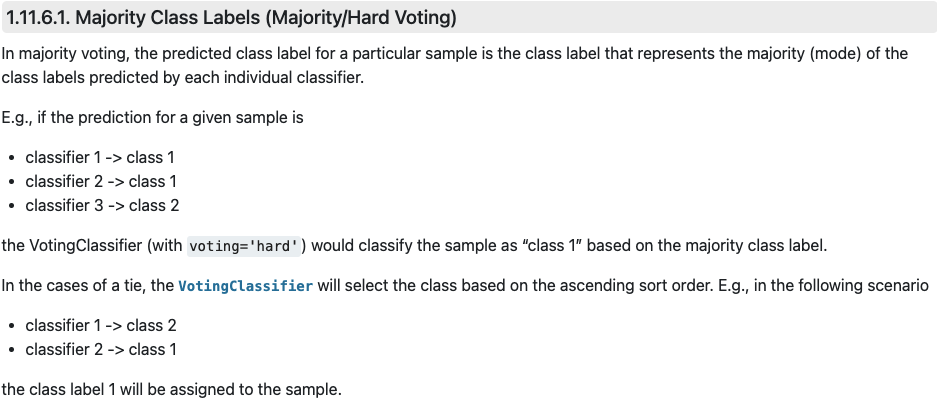

In [33]:
seed = 8
np.random.seed(seed)
max_voting_model = VotingClassifier(estimators = [("RF", rf_model), 
                                              ("XGB", xgb_model), 
                                              ("KNN", knn_model), 
                                              ("LogR", logr_model), 
                                              ("GB", gb_model)], 
                                voting="hard")
max_voting_model.fit(X_train, y_train)

VotingClassifier(estimators=[('RF',
                              RandomForestClassifier(n_estimators=400,
                                                     random_state=1)),
                             ('XGB', XGBClassifier()),
                             ('KNN', KNeighborsClassifier()),
                             ('LogR', LogisticRegression(max_iter=1000)),
                             ('GB', GradientBoostingClassifier())])

In [34]:
voting_pred = max_voting_model.predict(X_test)

In [35]:
voting_ensemble_test = test.copy()
pd.options.mode.chained_assignment = None
voting_ensemble_test["Pred_Fraud_num"] = voting_pred.tolist()
voting_ensemble_test["Pred_Fraud_type"] = [ "VS" if type == -1 else "BBS" if 
                                  type == 1 else "Clean" for type in 
                                  voting_ensemble_test["Pred_Fraud_num"] ]
voting_ensemble_test["Department"] = testing_data["Department"]
voting_ensemble_test["Precinct"] = testing_data["Precinct"]
voting_ensemble_test["Municipality"] = testing_data["Municipality"]

In [36]:
voting_ensemble_test.to_csv("ensemble_voting_results.csv", index=False)

In [37]:
col_names = ["Clean", "At_Risk", "BBS_Risk", "VS_Risk", "Avg_Turnout", 
             "Avg_MAS_vote"]
voting_ensemble_results = pd.DataFrame(columns = col_names)
counts = voting_ensemble_test.Pred_Fraud_type.value_counts()
clean = counts[0] / (counts[0] + counts[1] + counts[2])
tot_risk = (counts[1] + counts[2]) / (counts[0] + counts[1] + counts[2])
bbs = counts[1] / (counts[0] + counts[1] + counts[2])
vs = counts[2] / (counts[0] + counts[1] + counts[2])
avg_turnout = voting_ensemble_test["Turnout"].mean()
avg_vote = voting_ensemble_test["MAS.vote"].mean()
voting_ensemble_results.loc[len(avg_ensemble_results)] = [round(100*clean,2), 
                                                  round(100*tot_risk,2), 
                                                  round(100*bbs,2), 
                                                  round(100*vs,2), 
                                                  round(100*avg_turnout,2), 
                                                  round(avg_vote,2)]

Turnout and MAS vote share are the two main predictors.  Higher turnout is related to ballot box stuffing while higher MAS vote share is related to vote stealing.

In [38]:
voting_ensemble_results.to_csv("ensemble_voting_tot_results.csv", index=False)
voting_ensemble_results

,Clean,At_Risk,BBS_Risk,VS_Risk,Avg_Turnout,Avg_MAS_vote
1,85.86,14.14,9.44,4.7,89.8,0.46


In [39]:
col_names = ["Department", "Clean", "At_Risk", "BBS_Risk", "VS_Risk", 
             "Avg_Turnout", "Avg_MAS_vote"]
voting_ensemble_dep_results = pd.DataFrame(columns = col_names)
for dep in voting_ensemble_test["Department"].unique():
    counts = voting_ensemble_test[voting_ensemble_test["Department"] == 
                                  dep].Pred_Fraud_type.value_counts()
    clean = counts[0] / (counts[0] + counts[1] + counts[2])
    tot_risk = (counts[1] + counts[2]) / (counts[0] + counts[1] + counts[2])
    bbs = counts[1] / (counts[0] + counts[1] + counts[2])
    vs = counts[2] / (counts[0] + counts[1] + counts[2])
    avg_turnout = voting_ensemble_test[voting_ensemble_test["Department"] == 
                                       dep]["Turnout"].mean()
    avg_vote = voting_ensemble_test[voting_ensemble_test["Department"] == 
                                    dep]["MAS.vote"].mean()
    voting_ensemble_dep_results.loc[len(voting_ensemble_dep_results)] = [dep, 
                                                  round(100*clean,2), 
                                                  round(100*tot_risk,2), 
                                                  round(100*bbs,2), 
                                                  round(100*vs,2), 
                                                  round(100*avg_turnout,2), 
                                                  round(avg_vote,2)]
voting_ensemble_dep_results = voting_ensemble_dep_results.sort_values(by = 
                                                                      "Clean")
voting_ensemble_dep_results.reset_index(drop=True, inplace=True)

Results for each of the 9 departments across Bolivia.

In [40]:
voting_ensemble_dep_results.to_csv("ensemble_voting_dep_results.csv", 
                                   index=False)
voting_ensemble_dep_results

,Department,Clean,At_Risk,BBS_Risk,VS_Risk,Avg_Turnout,Avg_MAS_vote
0,Cochabamba,77.80,22.20,11.51,10.69,90.28,0.57
1,La Paz,84.00,16.00,12.86,3.14,91.75,0.53
2,Potosí,86.74,13.26,6.78,6.48,88.87,0.46
3,Oruro,88.08,11.92,9.79,2.13,91.09,0.47
4,Santa Cruz,89.20,10.80,8.73,2.07,88.83,0.34
5,Chuquisaca,91.43,8.57,5.69,2.88,88.41,0.40
6,Beni,92.26,7.74,5.41,2.33,86.17,0.34
7,Tarija,93.83,6.17,3.38,2.79,87.26,0.39
8,Pando,95.42,4.58,3.05,1.53,84.31,0.43


In [41]:
col_names = ["Municipality", "Department", "Clean", "At_Risk", "BBS_Risk", 
             "VS_Risk", "Avg_Turnout", "Avg_MAS_vote"]
voting_ensemble_mun_results = pd.DataFrame(columns = col_names)
for municip in voting_ensemble_test["Municipality"].unique():
  dep = voting_ensemble_test.loc[voting_ensemble_test["Municipality"] == 
                                 municip]["Department"].iloc[0]
  # counts = voting_ensemble_test[voting_ensemble_test["Municipality"] == 
  #                               municip].Pred_Fraud_type.value_counts()
  counts = voting_ensemble_test.loc[voting_ensemble_test.Municipality == municip, 
                                 'Pred_Fraud_type'].value_counts().reindex(voting_ensemble_test.Pred_Fraud_type.unique(), 
                                 fill_value=0)
  # if (len(counts) > 2): # will remove some municipalities from results
  clean = counts[0] / (counts[0] + counts[1] + counts[2])
  tot_risk = (counts[1] + counts[2]) / (counts[0] + counts[1] + counts[2])
  bbs = counts[1] / (counts[0] + counts[1] + counts[2])
  vs = counts[2] / (counts[0] + counts[1] + counts[2])
  avg_turnout = voting_ensemble_test[voting_ensemble_test["Municipality"] == municip]["Turnout"].mean()
  avg_vote = voting_ensemble_test[voting_ensemble_test["Municipality"] == municip]["MAS.vote"].mean()
  l = len(voting_ensemble_mun_results)
  voting_ensemble_mun_results.loc[l] = [municip, dep, round(100*clean,2), 
                                        round(100*tot_risk,2), 
                                        round(100*bbs,2), round(100*vs,2), 
                                        round(100*avg_turnout,2), 
                                        round(avg_vote,2)]
voting_ensemble_mun_results = voting_ensemble_mun_results.sort_values(by = 
                                                                      "Clean")
voting_ensemble_mun_results.reset_index(drop=True, inplace=True)

Results further broken down to the municipality level.

In [42]:
voting_ensemble_mun_results.to_csv("ensemble_voting_mun_results.csv", 
                                       index=False)
voting_ensemble_mun_results

,Municipality,Department,Clean,At_Risk,BBS_Risk,VS_Risk,Avg_Turnout,Avg_MAS_vote
0,San Pablo,Potosí,0.0,100.0,100.00,0.00,94.30,0.40
1,Malla,La Paz,0.0,100.0,66.67,33.33,96.27,0.83
2,Yunchará,Tarija,0.0,100.0,0.00,100.00,81.13,0.82
3,La Rivera,Oruro,0.0,100.0,100.00,0.00,95.60,0.42
4,Raqaypampa,Cochabamba,0.0,100.0,0.00,100.00,89.97,0.96
...,...,...,...,...,...,...,...,...
321,Choquecota,Oruro,100.0,0.0,0.00,0.00,86.50,0.84
322,Roboré,Santa Cruz,100.0,0.0,0.00,0.00,84.79,0.26
323,Curahuara de Carangas,Oruro,100.0,0.0,0.00,0.00,77.93,0.74
324,Tolata,Cochabamba,100.0,0.0,0.00,0.00,81.07,0.70


#Cross-Validation Accuracy Comparisons

Replitting the training data into training/testing data for further analysis.  This is necessary to perform certain measurements because we do not have any "true" labels for the real election (test) data.

In [43]:
seed = 8
X_train, X_test, y_train, y_test = train_test_split(train, train_labels, 
                                                    test_size = 0.5, 
                                                    shuffle = True,
                                                    random_state = seed)

Computes accuracy classification score for each of the ensemble classifiers.

In [44]:
cv = KFold(n_splits=5, random_state=seed, shuffle=True)
avg_model_acc = cross_val_score(avg_model, X_train, y_train, 
                                scoring="accuracy", cv=cv, n_jobs=1)
w_avg_model_acc = cross_val_score(weighted_avg_model, X_train, y_train, 
                                  scoring="accuracy", cv=cv, n_jobs=1)
max_vote_model_acc = cross_val_score(max_voting_model, X_train, y_train, 
                                     scoring="accuracy", cv=cv, n_jobs=1) 

In [45]:
print('Average Ensemble Accuracy: %.5f %%' % (100*np.mean(avg_model_acc)))
print('Weighted Average Ensemble Accuracy: %.5f %%' % (100*np.mean(w_avg_model_acc )))
print('Max Voting Ensemble Accuracy: %.5f %%' % (100*np.mean(max_vote_model_acc)))

Average Ensemble Accuracy: 97.60395 %
Weighted Average Ensemble Accuracy: 97.56747 %
Max Voting Ensemble Accuracy: 97.59179 %


#AUC-ROC Curves

In [46]:
n_classes = 3
seed = 8
X_train, X_test, y_train, y_test = train_test_split(train, train_labels, 
                                                    test_size = 0.5, 
                                                    shuffle = True,
                                                    random_state = seed)

##Curves for Average Ensemble

Computing probabilities for outcomes of VS, Clean, BBS (stored in y_score).

In [47]:
avg_model = VotingClassifier(estimators = [("RF", rf_model), 
                                              ("XGB", xgb_model), 
                                              ("KNN", knn_model), 
                                              ("LogR", logr_model), 
                                              ("GB", gb_model)], 
                                voting="soft", weights = [1,1,1,1,1])
avg_model.fit(X_train, y_train)
y_score = avg_model.predict_proba(X_test)

Binarizing the test labels (-1 -> [1,0,0], 0-> [0,1,0], 1-> [0,0,1]).

In [48]:
y_test_bin = label_binarize(y_test, classes=[-1, 0, 1])

Computing ROC curve and ROC area for each fraud risk label.

In [49]:
n_classes = 3 # classes = (VS, Clean, BBS)
fpr = dict() # false positive rate
tpr = dict() # true positive rate
roc_auc = dict()
for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

Plotting ROC curve for each label.  These results line up with patterns seen in SURF 2020 (such that BBS was more easily classified relative to other labels).  Take note of x and y limits of the plot.  It was necessary to "shrink" the dimensions in this way in order to visualize the curves.

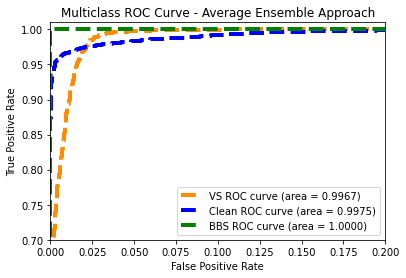

In [50]:
plt.figure()
lw = 4
plt.plot(fpr[0], tpr[0], color="darkorange", lw=lw, linestyle="--", 
         label="VS ROC curve (area = %0.4f)" % roc_auc[0])
plt.plot(fpr[1], tpr[1], color="blue", lw=lw, linestyle="--", 
         label="Clean ROC curve (area = %0.4f)" % roc_auc[1])
plt.plot(fpr[2], tpr[2], color="green", lw=lw, linestyle="--", 
         label="BBS ROC curve (area = %0.4f)" % roc_auc[2])

#plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 0.2])
plt.ylim([0.7, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve - Average Ensemble Approach")
plt.legend(loc="lower right")
plt.show()

##Curves for Weighted Average Ensemble

Computing probabilities for outcomes of VS, Clean, BBS (stored in y_score).

In [51]:
weighted_avg_model = VotingClassifier(estimators = [("RF", rf_model), 
                                              ("XGB", xgb_model), 
                                              ("KNN", knn_model), 
                                              ("LogR", logr_model), 
                                              ("GB", gb_model)], 
                                voting="soft", weights = [2,3,1,4,5])
weighted_avg_model.fit(X_train, y_train)
y_score = weighted_avg_model.predict_proba(X_test)

Binarizing the test labels (-1 -> [1,0,0], 0-> [0,1,0], 1-> [0,0,1]).

In [52]:
y_test_bin = label_binarize(y_test, classes=[-1, 0, 1])

Computing ROC curve and ROC area for each fraud risk label.

In [53]:
n_classes = 3 # classes = (VS, Clean, BBS)
fpr = dict() # false positive rate
tpr = dict() # true positive rate
roc_auc = dict()
for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

Plotting ROC curve for each label.  These results line up with patterns seen in SURF 2020 (such that BBS was more easily classified relative to other labels).  Take note of x and y limits of the plot.  It was necessary to "shrink" the dimensions in this way in order to visualize the curves.

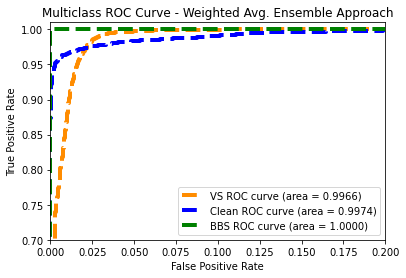

In [54]:
plt.figure()
lw = 4
plt.plot(fpr[0], tpr[0], color="darkorange", lw=lw, linestyle="--", 
         label="VS ROC curve (area = %0.4f)" % roc_auc[0])
plt.plot(fpr[1], tpr[1], color="blue", lw=lw, linestyle="--", 
         label="Clean ROC curve (area = %0.4f)" % roc_auc[1])
plt.plot(fpr[2], tpr[2], color="green", lw=lw, linestyle="--", 
         label="BBS ROC curve (area = %0.4f)" % roc_auc[2])

#plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 0.2])
plt.ylim([0.7, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve - Weighted Avg. Ensemble Approach")
plt.legend(loc="lower right")
plt.show()

#Confusion Matrices

Function to better visualize confustion matrix from confusion_matrix function from sklearn.  Adopted from the following source:

https://www.w3cschool.cn/doc_scikit_learn/scikit_learn-auto_examples-model_selection-plot_confusion_matrix.html

In [55]:
classes = ["VS", "Clean", "BBS"]
def plot_confusion_matrix(y_pred, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

  cm = confusion_matrix(y_test, y_pred)
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

## Avg. Ensemble

In [56]:
avg_y_pred = avg_model.predict(X_test)

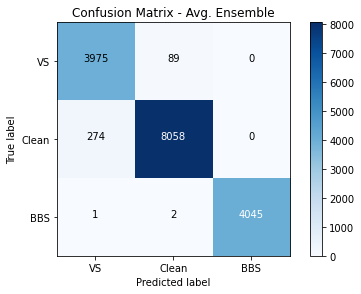

In [57]:
plt.figure()
plot_confusion_matrix(avg_y_pred, classes=classes, title="Confusion Matrix - Avg. Ensemble")
plt.show()

##Weighted Avg. Ensemble

In [58]:
w_avg_y_pred = weighted_avg_model.predict(X_test)

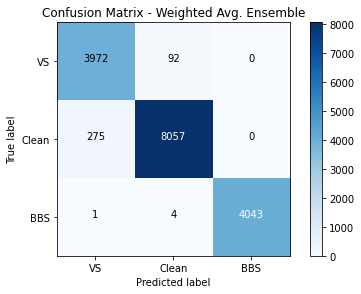

In [59]:
plt.figure()
plot_confusion_matrix(w_avg_y_pred, classes=classes, title="Confusion Matrix - Weighted Avg. Ensemble")
plt.show()

##Max Voting Ensemble

In [60]:
max_voting_model = VotingClassifier(estimators = [("RF", rf_model), 
                                              ("XGB", xgb_model), 
                                              ("KNN", knn_model), 
                                              ("LogR", logr_model), 
                                              ("GB", gb_model)], 
                                voting="hard")
max_voting_model.fit(X_train, y_train)

VotingClassifier(estimators=[('RF',
                              RandomForestClassifier(n_estimators=400,
                                                     random_state=1)),
                             ('XGB', XGBClassifier()),
                             ('KNN', KNeighborsClassifier()),
                             ('LogR', LogisticRegression(max_iter=1000)),
                             ('GB', GradientBoostingClassifier())])

In [61]:
max_vote_y_pred = max_voting_model.predict(X_test)

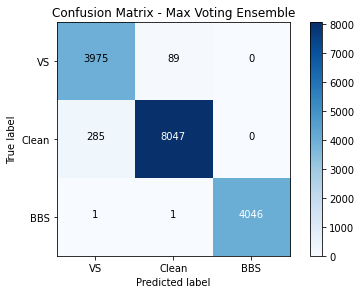

In [62]:
plt.figure()
plot_confusion_matrix(max_vote_y_pred, classes=classes, title="Confusion Matrix - Max Voting Ensemble")
plt.show()